<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Superposition and Entanglement*_ 


The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Antonio Córcoles, Andrew Cross, Anna Phan

## Introduction
Many people tend to think quantum physics is hard math, but this is not actually true. Quantum concepts are very similar to those seen in the linear algebra classes you may have taken as a freshman in college, or even in high school. The challenge of quantum physics is the necessity to accept counter-intuitive ideas, and its lack of a simple underlying theory. We believe that if you can grasp the following two Principles, you will have a good start: 
1. [A physical system in a perfectly definite state can still behave randomly.](#section1)
2. [Two systems that are too far apart to influence each other can nevertheless behave in ways that, though individually random, are somehow strongly correlated.](#section2)

## Getting Started
Please see [Getting Started with QISKit](../tools/getting_started.ipynb) if you would like to understand how to get started with QISKit. This tutorial will be giving an introduction to superposition and entanglement. Note that all the examples will be run on a simulator to avoid the queues for running on a quantum processor, however, all examples can be run on real devices and comments will be included to allow you to do so. 

In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pprint import pprint

# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import QuantumProgram
from qiskit.backends import discover_local_backends, discover_remote_backends

# import basic plot tools
from qiskit.tools.visualization import plot_histogram, circuit_drawer

In [3]:
def lowest_pending_jobs(api):
    """Returns the backend with lowest pending jobs."""
    remote_backends = discover_remote_backends(api)
    remote_backends.remove('ibmqx_hpc_qasm_simulator')
    remote_backends.remove('ibmqx_qasm_simulator')
    device_status = [api.backend_status(backend) for backend in remote_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['backend'] 

In [4]:
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

#backend = lowest_pending_jobs(api)
#print("the best backend is " + backend)

backend = 'local_qasm_simulator' # the backend to run on
shots = 1024    # the number of shots in the experiment 

## Quantum States - Basis States and Superpositions<a id='section1'></a>

The first Principle above tells us that the results of measuring a quantum state may be random or deterministic, depending on what basis is used. To demonstrate, we will first introduce the computational (or standard) basis for a qubit. 

The computational basis is the set containing the ground and excited state $\{|0\rangle,|1\rangle\}$, which also corresponds to the following vectors: 

$$|0\rangle =\begin{pmatrix} 1 \\ 0 \end{pmatrix}$$
$$|1\rangle =\begin{pmatrix} 0 \\ 1 \end{pmatrix}$$

In Python these are represented by

In [5]:
zero = np.array([[1],[0]])
one = np.array([[0],[1]])

In our quantum processor system (and many other physical quantum processors) it is natural for all qubits to start in the $|0\rangle$ state, known as the ground state. To make the $|1\rangle$ (or excited) state, we use the operator 

$$ X =\begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}.$$

This $X$ operator is often called a bit-flip because it exactly implements the following:

$$X: |0\rangle  \rightarrow  |1\rangle$$
$$X: |1\rangle \rightarrow |0\rangle.$$

In Python this can be represented by the following:

In [6]:
X = np.array([[0,1],[1,0]])
print(np.dot(X,zero))
print(np.dot(X,one))

[[0]
 [1]]
[[1]
 [0]]


Next, we give the two quantum circuits for preparing and measuring a single qubit in the ground and excited states using QISKit.

In [7]:
# Creating registers
qr = QuantumRegister('qr', 1)
cr = ClassicalRegister('cr', 1)

# Quantum circuit ground 
qc_ground = QuantumCircuit(qr, cr)
qc_ground.measure(qr[0], cr[0])

# Quantum circuit excited 
qc_excited = QuantumCircuit(qr, cr)
qc_excited.x(qr)
qc_excited.measure(qr[0], cr[0])


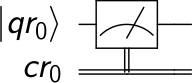

In [8]:
circuit_drawer(qc_ground)

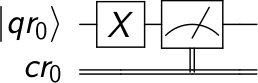

In [9]:
circuit_drawer(qc_excited)

Here we have created two jobs with different quantum circuits; the first to prepare the ground state, and the second to prepare the excited state. Now we can run the prepared jobs.

In [10]:

circuits = ['ground', 'excited']
Q_program = QuantumProgram()
Q_program.add_circuit('ground',qc_ground)
Q_program.add_circuit('excited',qc_excited)
Q_program.get_qasms(circuits)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

After the run has been completed, the data can be extracted from the API output and plotted.

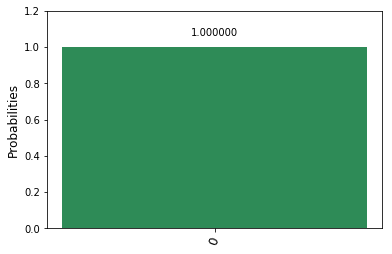

In [11]:
plot_histogram(result.get_counts('ground'))

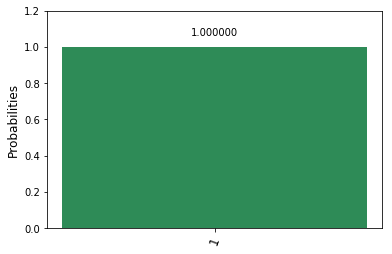

In [12]:
plot_histogram(result.get_counts('excited'))

Here we see that the qubit is in the $|0\rangle$ state with 100% probability for the first circuit and in the $|1\rangle$ state with 100% probability for the second circuit. If we had run on a quantum processor rather than the simulator, there would be a difference from the ideal perfect answer due to a combination of measurement error, preparation error, and gate error (for the $|1\rangle$ state). 

Up to this point, nothing is different from a classical system of a bit. To go beyond, we must explore what it means to make a superposition. The operation in the quantum circuit language for generating a superposition is the Hadamard gate, $H$. Let's assume for now that this gate is like flipping a fair coin. The result of a flip has two possible outcomes, heads or tails, each occurring with equal probability. If we repeat this simple thought experiment many times, we would expect that on average we will measure as many heads as we do tails. Let heads be $|0\rangle$ and tails be $|1\rangle$. 

Let's run the quantum version of this experiment. First we prepare the qubit in the ground state $|0\rangle$. We then apply the Hadamard gate (coin flip). Finally, we measure the state of the qubit. Repeat the experiment 1024 times (shots). As you likely predicted, half the outcomes will be in the $|0\rangle$ state and half will be in the $|1\rangle$ state.

Try the program below.

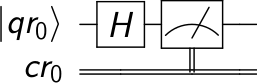

In [13]:
# Quantum circuit superposition 
qc_superposition = QuantumCircuit(qr, cr)
qc_superposition.h(qr)
qc_superposition.measure(qr[0], cr[0])

circuit_drawer(qc_superposition)

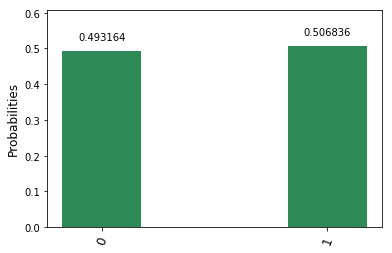

In [14]:
circuits = ['superposition']
Q_program.add_circuit('superposition', qc_superposition)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

plot_histogram(result.get_counts('superposition'))

Indeed, much like a coin flip, the results are close to 50/50 with some non-ideality due to errors (again due to state preparation, measurement, and gate errors). So far, this is still not unexpected. Let's run the experiment again, but this time with two $H$ gates in succession. If we consider the $H$ gate to be analog to a coin flip, here we would be flipping it twice, and still expecting a 50/50 distribution. 

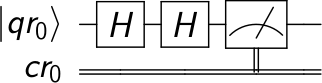

In [15]:
# Quantum circuit two Hadamards 
qc_twohadamard = QuantumCircuit(qr, cr)
qc_twohadamard.h(qr)
qc_twohadamard.barrier()
qc_twohadamard.h(qr)
qc_twohadamard.measure(qr[0], cr[0])

circuit_drawer(qc_twohadamard)

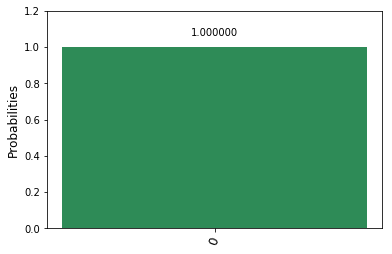

In [16]:
circuits = ['twohadamard']
Q_program.add_circuit('twohadamard', qc_twohadamard)
result= Q_program.execute(circuits, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

plot_histogram(result.get_counts('twohadamard'))

This time, the results are surprising. Unlike the classical case, with high probability the outcome is not random, but in the $|0\rangle$ state. *Quantum randomness* is not simply like a classical random coin flip. In both of the above experiments, the system (without noise) is in a definite state, but only in the first case does it behave randomly. This is because, in the first case, via the $H$ gate, we make a uniform superposition of the ground and excited state, $(|0\rangle+|1\rangle)/\sqrt{2}$, but then follow it with a measurement in the computational basis. The act of measurement in the computational basis forces the system to be in either the $|0\rangle$ state or the $|1\rangle$ state with an equal probability (due to the uniformity of the superposition). In the second case, we can think of the second $H$ gate as being a part of the final measurement operation; it changes the measurement basis from the computational basis to a *superposition* basis. The following equations illustrate the action of the $H$ gate on the computational basis states:
$$H: |0\rangle  \rightarrow  |+\rangle=\frac{|0\rangle+|1\rangle}{\sqrt{2}}$$
$$H: |1\rangle \rightarrow |-\rangle=\frac{|0\rangle-|1\rangle}{\sqrt{2}}.$$
We can redefine this new transformed basis, the superposition basis, as the set {$|+\rangle$, $|-\rangle$}. We now have a different way of looking at the second experiment above. The first $H$ gate prepares the system into a superposition state, namely the $|+\rangle$ state. The second $H$ gate followed by the standard measurement changes it into a measurement in the superposition basis. If the measurement gives 0, we can conclude that the system was in the $|+\rangle$ state before the second $H$ gate, and if we obtain 1, it means the system was in the $|-\rangle$ state. In the above experiment we see that the outcome is mainly 0, suggesting that our system was in the $|+\rangle$ superposition state before the second $H$ gate. 


The math is best understood if we represent the quantum superposition state $|+\rangle$ and $|-\rangle$ by: 

$$|+\rangle =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 1 \end{pmatrix}$$
$$|-\rangle =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ -1 \end{pmatrix}$$

A standard measurement, known in quantum mechanics as a projective or von Neumann measurement, takes any superposition state of the qubit and projects it to either the state $|0\rangle$ or the state $|1\rangle$ with a probability determined by:

$$P(i|\psi) = |\langle i|\psi\rangle|^2$$ 

where $P(i|\psi)$ is the probability of measuring the system in state $i$ given preparation $\psi$.

We have written the Python function ```state_overlap``` to return this: 

In [17]:
state_overlap = lambda state1, state2: np.absolute(np.dot(state1.conj().T,state2))**2

Now that we have a simple way of going from a state to the probability distribution of a standard measurement, we can go back to the case of a superposition made from the Hadamard gate. The Hadamard gate is defined by the matrix:

$$ H =\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$$

The $H$ gate acting on the state $|0\rangle$ gives:

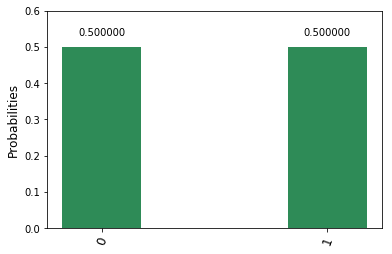

In [18]:
Hadamard = np.array([[1,1],[1,-1]],dtype=complex)/np.sqrt(2)
psi1 = np.dot(Hadamard,zero)
P0 = state_overlap(zero,psi1)
P1 = state_overlap(one,psi1)
plot_histogram({'0' : P0.item(0), '1' : P1.item(0)})

which is the ideal version of the first superposition experiment. 

The second experiment involves applying the Hadamard gate twice. While matrix multiplication shows that the product of two Hadamards is the identity operator (meaning that the state $|0\rangle$ remains unchanged), here (as previously mentioned) we prefer to interpret this as doing a measurement in the superposition basis. Using the above definitions, you can show that $H$ transforms the computational basis to the superposition basis.

In [19]:
print(np.dot(Hadamard,zero))
print(np.dot(Hadamard,one))

[[0.70710678+0.j]
 [0.70710678+0.j]]
[[ 0.70710678+0.j]
 [-0.70710678+0.j]]


## Entanglement<a id='section2'></a>

The core idea behind the second Principle is *entanglement*. Upon reading the Principle, one might be inclined to think that entanglement is simply strong correlation between two entitities -- but entanglement goes well beyond mere perfect (classical) correlation. If you and I read the same paper, we will have learned the same information. If a third person comes along and reads the same paper they <i>also</i> will have learned this information. All three persons in this case are perfectly correlated, and they will remain correlated even if they are separated from each other. 

The situation with quantum entanglement is a bit more subtle. In the quantum world, you and I could read the same quantum paper, and yet we will not learn what information is actually contained in the paper until we get together and share our information. However, when we are together, we find that we can unlock more information from the paper than we initially thought possible. Thus, quantum entanglement goes much further than perfect correlation.

To demonstrate this, we will define the controlled-NOT (CNOT) gate and the composition of two systems. The convention we use in the Quantum Experience is to label states by writing the first qubit's name in the rightmost position, thereby allowing us to easily convert from binary to decimal. As a result, we define the tensor product between operators $q_0$ and $q_1$ by $q_1\otimes q_0$. 

Taking $q_0$ as the control and $q_1$ as the target, the CNOT with this representation is given by

$$ CNOT =\begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\0& 0& 1 & 0\\0 & 1 & 0 & 0 \end{pmatrix},$$

which is non-standard in the quantum community, but more easily connects to classical computing, where the least significant bit (LSB) is typically on the right. An entangled state of the two qubits can be made via an $H$ gate on the control qubit, followed by the CNOT gate. This generates a particular maximally entangled two-qubit state known as a Bell state, named after John Stewart Bell ([learn more about Bell and his contributions to quantum physics and entanglement](https://en.wikipedia.org/wiki/John_Stewart_Bell)). 


To explore this, we can prepare an entangled state of two qubits, and then ask questions about the qubit states. The questions we can ask are:
* What is the state of the first qubit in the standard basis?
* What is the state of the first qubit in the superposition basis?
* What is the state of the second qubit in the standard basis?
* What is the state of the second qubit in the superposition basis?
* What is the state of both qubits in the standard basis?
* what is the state of both qubits in the superposition basis?

Below is a program with six such circuits for these six questions.

In [20]:

Q_program = QuantumProgram()
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url']) # include if running on ibmqx2

# Creating registers
q2 = QuantumRegister('q2', 2)
c2 = ClassicalRegister('c2', 2)

# quantum circuit to make an entangled bell state 
bell = QuantumCircuit(q2, c2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])

# quantum circuit to measure q0 in the standard basis
measureIZ = QuantumCircuit(q2, c2)
measureIZ.measure(q2[0], c2[0])

# quantum circuit to measure q0 in the superposition basis 
measureIX = QuantumCircuit(q2, c2)
measureIX.h(q2[0])
measureIX.measure(q2[0], c2[0])

# quantum circuit to measure q1 in the standard basis
measureZI = QuantumCircuit(q2, c2)
measureZI.measure(q2[1], c2[1])

# quantum circuit to measure q1 in the superposition basis 
measureXI = QuantumCircuit(q2, c2)
measureXI.h(q2[1])
measureXI.measure(q2[1], c2[1])

# quantum circuit to measure q in the standard basis 
measureZZ = QuantumCircuit(q2, c2)
measureZZ.measure(q2[0], c2[0])
measureZZ.measure(q2[1], c2[1])

# quantum circuit to measure q in the superposition basis 
measureXX = QuantumCircuit(q2, c2)
measureXX.h(q2[0])
measureXX.h(q2[1])
measureXX.measure(q2[0], c2[0])
measureXX.measure(q2[1], c2[1])

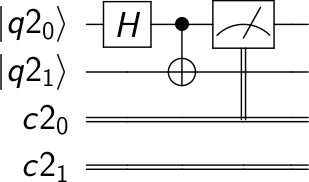

In [21]:
circuit_drawer(bell+measureIZ)

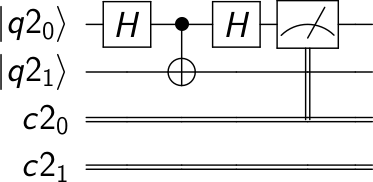

In [22]:
circuit_drawer(bell+measureIX)

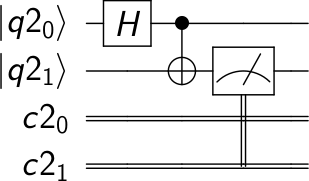

In [23]:
circuit_drawer(bell+measureZI)

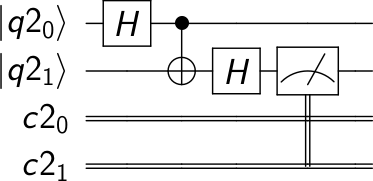

In [24]:
circuit_drawer(bell+measureXI)

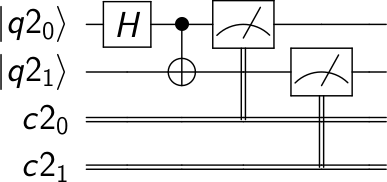

In [25]:
circuit_drawer(bell+measureZZ)

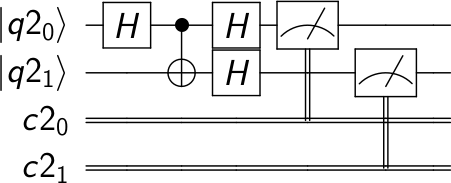

In [26]:
circuit_drawer(bell+measureXX)

Let's begin by running just the first two questions, looking at the results of the first qubit ($q_0$) using a computational and then a superposition measurement.

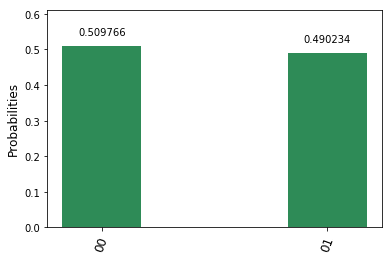

In [27]:
Q_program.add_circuit("bell_measureIZ", bell+measureIZ )
Q_program.add_circuit("bell_measureIX", bell+measureIX )
Q_program.add_circuit("bell_measureZI", bell+measureZI )
Q_program.add_circuit("bell_measureXI", bell+measureXI )
Q_program.add_circuit("bell_measureZZ", bell+measureZZ )
Q_program.add_circuit("bell_measureXX", bell+measureXX )

circuits = ["bell_measureIZ", "bell_measureIX", "bell_measureZI", "bell_measureXI", "bell_measureZZ", "bell_measureXX"]
result = Q_program.execute(circuits[0:2], backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)
plot_histogram(result.get_counts("bell_measureIZ"))

In [28]:
result.get_data("bell_measureIZ")

{'counts': {'00': 522, '01': 502}}

We find that the result is random. Half the time $q_0$ is in  $|0\rangle$, and the other half it is in the $|1\rangle$ state. You may wonder whether this is like the superposition from earlier in the tutorial. Maybe the qubit has a perfectly definite state, and we are simply measuring in another basis.  What would you expect if you did the experiment and measured in the superposition basis? Recall we do this by adding an $H$ gate before the measurement...which is exactly what we have checked with the second question.

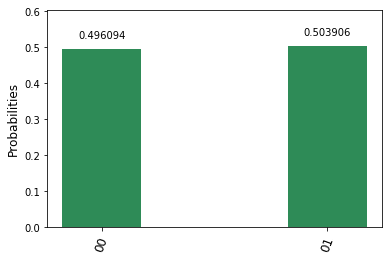

In [29]:
plot_histogram(result.get_counts("bell_measureIX"))

In this case, we see that the result is still random, regardless of whether we measure in the computational or the superposition basis. This tells us that we actually know nothing about the first qubit. What about the second qubit, $q_1$? The next lines will run experiments measuring the second qubit in both the computational and superposition bases.

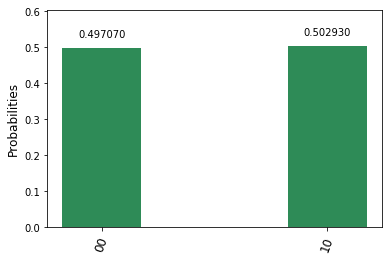

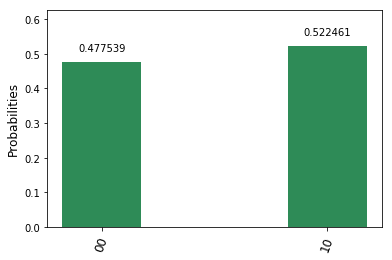

In [30]:
result = Q_program.execute(circuits[2:4], backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)
plot_histogram(result.get_counts("bell_measureZI"))
plot_histogram(result.get_counts("bell_measureXI"))

Once again, all the experiments give random outcomes. It seems we know nothing about either qubit in our system! In our previous analogy, this is equivalent to two readers separately reading a quantum paper and extracting no information whatsoever from it on their own.

What do you expect, however, when the readers get together?  Below we will measure both in the joint computational basis. 

In [31]:
result = Q_program.execute(circuits[4:6], backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)

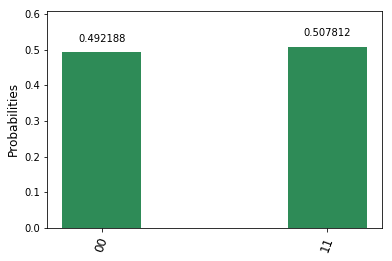

In [32]:
plot_histogram(result.get_counts("bell_measureZZ"))

Here we see that with high probability, if $q_0$ is in state 0, $q_1$ will be in 0 as well; the same goes if $q_0$ is in state 1. They are perfectly correlated.

What about if we measure both in the superposition basis?  

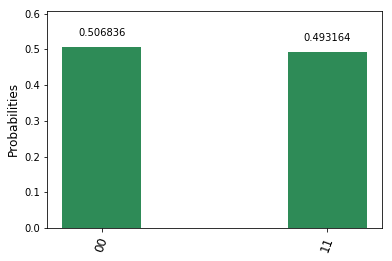

In [33]:
plot_histogram(result.get_counts("bell_measureXX"))

Here we see that the system **also** has perfect correlations (accounting for experimental noise). Therefore, if $q_0$ is measured in state $|0\rangle$, we know $q_1$ is in this state as well; likewise, if $q_0$ is measured in state $|+\rangle$, we know $q_1$ is also in this state. These correlations have led to much confusion in science, because any attempt to relate the unusual behavior of quantum entanglement to our everyday experiences is a fruitless endeavor. 

Finally, we need to point out that having correlated outcomes does not necessarily imply that what we are observing is an entangled state. What would we observe, for example, if we prepared half of our shots in the $|00\rangle$ state and half of the shots in the $|11\rangle$ state? Let's have a look

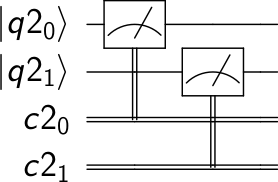

In [34]:
# quantum circuit to make a mixed state 
mixed1 = QuantumCircuit(q2, c2)
mixed2 = QuantumCircuit(q2, c2)
mixed2.x(q2)
mixed1.measure(q2[0], c2[0])
mixed1.measure(q2[1], c2[1])
mixed2.measure(q2[0], c2[0])
mixed2.measure(q2[1], c2[1])

circuit_drawer(mixed1)

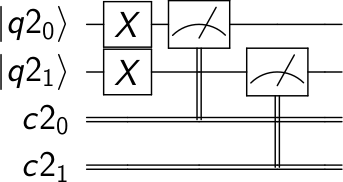

In [35]:
circuit_drawer(mixed2)

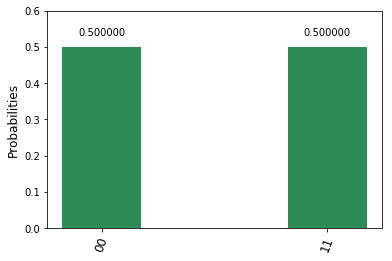

In [36]:
mixed_state = ["mixed1", "mixed2"]
Q_program.add_circuit("mixed1", mixed1 )
Q_program.add_circuit("mixed2", mixed2 )
result = Q_program.execute(mixed_state, backend=backend, shots=shots, max_credits=3, wait=10, timeout=240)
counts1 = result.get_counts(mixed_state[0])
counts2 = result.get_counts(mixed_state[1])
from collections import Counter
ground = Counter(counts1)
excited = Counter(counts2)
plot_histogram(ground+excited)

We do see the same kind of correlation indeed as we observed in the "bell_measureZZ" circuit. But we know this is not an entangled state! All we have done is leave the qubits in their ground state for some of the shots and flip both qubits for some of the shots. This is called a mixed state and it is a classical state. Now, would we observe a similar outcome if we measured this mixed state in the superposition basis? We will leave this for the reader to try.

This is just a taste of what happens in the quantum world. Please continue to [Entanglement revisited](entanglement_revisited.ipynb) to explore further!

In [37]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
